In [1]:
import numpy as np
import pandas as pd
from das_fk import to_fk_domain, vfk_crop_sum
from das_fk.utils import read_PASSCAL_segy, downsample_das
from das_fk.visualization import show_data, plot_fk, plot_velocity

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

# Channel positions

In [5]:
location = pd.read_csv("../data/das_info.csv")
location.head()

,index,latitude,longitude,elevation_m
0,25,35.645200,-117.667931,0.0
1,26,35.645272,-117.667929,0.0
2,27,35.645344,-117.667928,0.0
3,28,35.645416,-117.667927,0.0
4,29,35.645488,-117.667926,0.0


In [6]:
location_new = location[120:]

# Preprocess

In [7]:
channel_index = location_new["index"].to_numpy()
channel_lat = location_new["latitude"].to_numpy()
channel_lon = location_new["longitude"].to_numpy()

In [8]:
data, das_time = read_PASSCAL_segy("../data/2020062417.segy")

In [9]:
# Option 1: Downsample the data.
strain, das_time = downsample_das(data[channel_index, :], das_time, fd=25)

# Option 2: Don't downsample
# strain = data[channel_index, :]

# Option 3: Just downsample
# strain, das_time = downsample_das(data, das_time, fd=25)

# Option 4: Don't downsample and keep all channels
# strain = data

In [10]:
# Highpass filter
# Mainly to drop DC component
from scipy.signal import butter, sosfiltfilt

dt = das_time[1] - das_time[0] # (it is constant)
sos = butter(4, 0.5*2*dt, output='sos', btype='high')
strain_filt = sosfiltfilt(sos, strain, axis=1)

In [11]:
# Median filter
# For salt and pepper noise, outliers and bad channels.
from scipy.signal import medfilt2d

kernel_size = (3,1) # Only along channels
strain_prep = medfilt2d(strain_filt, kernel_size=kernel_size)

# Visualize

In [12]:
start_id = np.argmin(np.abs(das_time-2475))
stop_id = np.argmin(np.abs(das_time-2525))
start_id, stop_id

(61875, 63125)

In [13]:
strain_fft, frequency, wavenumber = to_fk_domain(strain_prep[:, start_id:stop_id],
                                                   dt=dt, dl=10)
strain_power = np.abs(strain_fft)

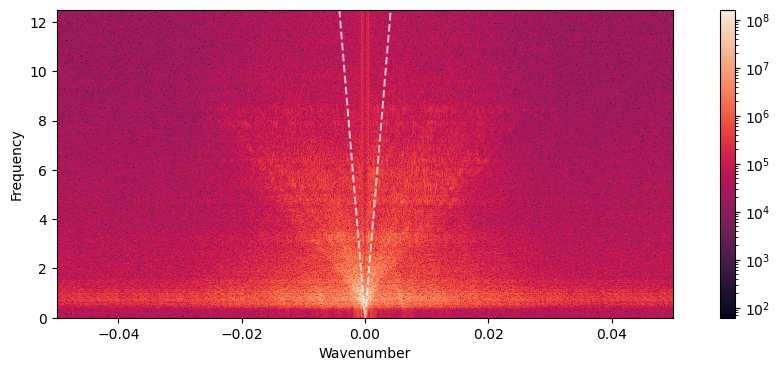

In [14]:
fig, ax = plot_fk(strain_power, frequency, wavenumber)
plot_velocity(3000, frequency, wavenumber, ax, color="w")

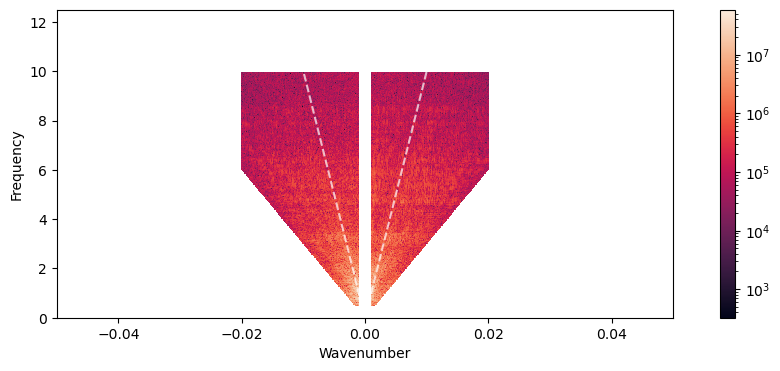

In [16]:
v = (300, np.inf)
f = (0.5, 10)
k = (0.001, 0.02)

total_sum, strain_power_cropped = vfk_crop_sum(strain_power, v, f, k, dt, dl=10, testing=True)

fig, ax = plot_fk(strain_power_cropped, frequency, wavenumber)
plot_velocity(1000, frequency, wavenumber, ax, color="w")